In [2]:
from mimetypes import init
import shutil
import PIL
from cv2 import imread
from flask_bootstrap import Bootstrap
from flask import Flask, render_template, request
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image,ImageOps,ImageEnhance
import albumentations
import torch
import numpy as np
from torchvision.utils import make_grid
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
from skimage import io
import os
import glob
from ctc_decoder import best_path, beam_search
import torch
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_sequence
import torchvision.models as models
from torch.utils.model_zoo import load_url
import torchvision.transforms as T
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import cv2
import torch
from  torch import nn
from torch.nn import functional as F
from pprint import  pprint

In [3]:
classes=[' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A',
       'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a',
       'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [4]:
class CaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(CaptchaModel, self).__init__()
        self.conv_1 = nn.Conv2d(3, 128, kernel_size=(3, 3), padding=(1, 1))
        self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1))
        self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.linear1 = nn.Linear(1600, 64)
        self.drop_1 = nn.Dropout(0.2)

        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars + 1)

    def forward(self, images,lens, targets=None):
        bs, c, h, w = images.size()
        #print(bs, c, h, w)
        x = F.relu(self.conv_1(images))
        #print(x.size())
        x = self.pool_1(x)
        #print(x.size())
        x = F.relu(self.conv_2(x))
        #print(x.size())
        x = self.pool_2(x) # 1, 64, 18, 75
        #print(x.size())
        x = x.permute(0, 3, 1, 2) # 1, 75 , 64, 18
        #print(x.size())
        x = x.view(bs, x.size(1), -1)
        #print(x.size())
        x = self.linear1(x)
        x = self.drop_1(x)
        #print(x.size()) # torch.Size([1, 75, 64]) -> we have 75 time steps and for each time step we have 64 values
        x, _ = self.gru(x)
        #print(x.size())
        x = self.output(x)
        #print(x.size())
        x = x.permute(1, 0, 2) # bs, time steps, values -> CTC LOSS expects it to be
        if targets is not None:
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(
                size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32
            )
            #print(input_lengths)
            #target_lengths = torch.full(
            #    size=(bs,), fill_value=targets.size(1), dtype=torch.int32
            #)
            #print(target_lengths)
            target_lengths = torch.tensor(
                lens, dtype=torch.int32
            )
            loss = nn.CTCLoss(blank=64)(
                log_probs, targets, input_lengths, lens
            )
            return x, loss

        return x, None
class config:
    IMAGE_WIDTH = 500
    IMAGE_HEIGHT = 100
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
def predictCrop(imgPath):
    img = Image.open(imgPath).convert("RGB")
    test_model = CaptchaModel(num_chars=64)
    test_model.to(config.DEVICE)
    PATH = 'Words_best_score.pt'
    test_model.load_state_dict(torch.load(PATH))
    img = img.resize((config.IMAGE_WIDTH, config.IMAGE_HEIGHT), resample=Image.BILINEAR)
    img = np.array(img)
    aug = albumentations.Compose([albumentations.Normalize(always_apply=True)])
    augmented = aug(image=img)
    img = augmented["image"]
    img = torch.tensor(img, dtype=torch.float)
    img = img.permute(2,0,1)
    img = img.unsqueeze(0)
    img = img.to(config.DEVICE)
    test_model.eval()
    with torch.no_grad():
        result_rnn,_ = test_model(images=img,lens=None)
    return result_rnn
def decode_predictions_3(preds):
    #print(preds.shape) # [125, 8, 30] timesteps,bs , classes
    #preds = preds.permute(1, 0, 2) 
    #print(preds)
    preds = torch.softmax(preds, 2)
    #print(preds.shape) # [8, 125, 30] bs, timesteps, classes
    
    #preds = torch.argmax(preds, 2)
    #print(preds.shape) # [8, 125]
    preds = preds.detach().cpu().numpy()
    #print(preds.shape) # (8, 125)

    #print(preds.shape)
    for i in range(preds.shape[1]):
        #print(preds[:,i,:].shape)
        #print(preds[:,i,:])
        aux =  preds[:,i,:] 
        #print(aux.shape) # (125, 30)
        #print(f'Best path: "{best_path_1(aux, test)}"')
        print(f'Beam search: "{beam_search(aux,classes)}"')
        res=beam_search(aux,classes)
    return res

In [15]:
decode_predictions_3(predictCrop(r'processing\Image\crops\Amount in words\Image2.jpg'))


Beam search: "Thousand and Forty Eight "


'Thousand and Forty Eight '

In [13]:
img = Image.open(r'processing\Image\crops\Amount in words\Image2.jpg').convert("RGB")
img = img.resize((config.IMAGE_WIDTH, config.IMAGE_HEIGHT), resample=Image.BILINEAR)

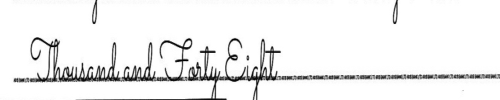

In [14]:
img

In [51]:
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte
from typing import Tuple

In [52]:
def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    """ Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.
    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------
    """
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    """ Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size
    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def remove_background(img: np.ndarray) -> np.ndarray:
        """ Remove noise using OTSU's method.
        Parameters
        ----------
        img : np.ndarray
            The image to be processed
        Returns
        -------
        np.ndarray
            The image with background removed
        """

        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    """ Crops an image to the desired size without stretching it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size
    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image
        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of multiple images
        Parameters
        ----------
        imgs : np.ndarray (N x C x H_old x W_old)
            The images to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray (N x C x H x W)
            The cropped images
        """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))


In [4]:
pd.__version__

'1.2.4'